In [0]:
%tensorflow_version 1.x

### Imports

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
import warnings

warnings.filterwarnings(action='ignore')

import glob
import random
import cv2
from random import shuffle

In [7]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

### Generators

In [0]:
def image_generator(files, batch_size = 16, sz = (256, 256)):
  
  while True: 
    batch = np.random.choice(files, size = batch_size)    
    batch_x = []
    batch_y = []
    
    for f in batch:
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = to_categorical(batch_y)

    yield (batch_x, batch_y)          

In [0]:
batch_size = 16 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [11]:
print (x.shape, y.shape)

(16, 256, 256, 3) (16, 256, 256, 2)


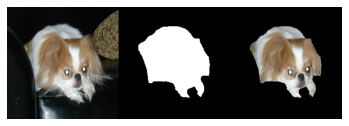

In [12]:
plt.axis('off')

img = x[0]

msk = y[0]
msk = msk[:,:,1]
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

### IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.

    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f

    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
def block_residual(x, nKernels):
  identity = x

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  
  return x + identity

### Model

In [0]:
from tensorflow.keras.layers import concatenate

def mnet(sz = (256, 256, 3)):
  nkernel = 16
  x = Input(sz)
  input_feature = Conv2D(16, (1,1), activation='relu')(x)

  L_Leg_1 = MaxPooling2D((2,2)) (input_feature)
  L_Leg_2 = MaxPooling2D((2,2)) (L_Leg_1)
  L_Leg_3 = MaxPooling2D((2,2)) (L_Leg_2)
  L_Leg_4 = MaxPooling2D((2,2)) (L_Leg_3)

  layer_1_1 = Conv2D(nkernel, (3, 3), activation='relu', padding='same')(input_feature)
  layer_1_1 = BatchNormalization()(layer_1_1)

  print(layer_1_1.shape)
  print(input_feature.shape)

  layer_1_c = concatenate([layer_1_1, input_feature])

  layer_1_2 = Conv2D(nkernel*2, (3, 3), activation='relu', padding='same')(layer_1_c)
  layer_1_2 = BatchNormalization()(layer_1_2)
  layer_1_p = MaxPooling2D((2, 2)) (layer_1_2)

  layer_2_1 = concatenate([L_Leg_1, layer_1_p])

  layer_2_2 = Conv2D(nkernel*2, (3, 3), activation='relu', padding='same') (layer_2_1)
  layer_2_2 = BatchNormalization()(layer_2_2)
  layer_2_c = concatenate([layer_2_2, layer_1_p])

  layer_2_3 = Conv2D(nkernel*3, (3, 3), activation='relu', padding='same')(layer_2_c)
  layer_2_3 = BatchNormalization()(layer_2_3)
  layer_2_p = MaxPooling2D((2, 2)) (layer_2_3)

  layer_3_1 = concatenate([L_Leg_2, layer_2_p])

  layer_3_2 = Conv2D(nkernel*3, (3, 3), activation='relu', padding='same') (layer_3_1)
  layer_3_2 = BatchNormalization()(layer_3_2)
  layer_3_c = concatenate([layer_3_2, layer_2_p])

  layer_3_3 = Conv2D(nkernel*4, (3, 3), activation='relu', padding='same') (layer_3_c)
  layer_3_3 = BatchNormalization()(layer_3_3)
  layer_3_p = MaxPooling2D((2, 2)) (layer_3_3)

  layer_4_1 = concatenate([L_Leg_3, layer_3_p])

  layer_4_2 = Conv2D(nkernel*4, (3, 3), activation='relu', padding='same') (layer_4_1)
  layer_4_2 = BatchNormalization()(layer_4_2)
  layer_4_c = concatenate([layer_4_2, layer_3_p])

  layer_4_3 = Conv2D(nkernel*6, (3 ,3), activation='relu', padding='same')(layer_4_c)
  layer_4_3 = BatchNormalization()(layer_4_3)
  layer_4_p = MaxPooling2D((2, 2)) (layer_4_3)

  layer_5_1 = concatenate([L_Leg_4, layer_4_p])

  layer_5_2 = Conv2D(nkernel*6, (3, 3), activation='relu', padding='same') (layer_5_1)
  layer_5_2 = BatchNormalization()(layer_5_2)

  layer_5_3 = Conv2D(nkernel*8, (3, 3), activation='relu', padding='same') (layer_5_2)
  layer_5_3 = BatchNormalization()(layer_5_3)

  layer_5_4 = Conv2D(nkernel*6, (3, 3), activation='relu', padding='same') (layer_5_3)
  layer_5_4 = BatchNormalization()(layer_5_4)

  layer_6_u = UpSampling2D((2, 2)) (layer_5_4)
  layer_6_1 = concatenate([layer_6_u, layer_4_3])

  layer_6_2 = Conv2D(nkernel*6, (3, 3), activation='relu', padding='same') (layer_6_1)
  layer_6_2 = BatchNormalization()(layer_6_2)

  layer_6_c = concatenate([layer_6_2, layer_6_u])
  layer_6_3 = Conv2D(nkernel*4, (3, 3), activation='relu', padding='same') (layer_6_c)
  layer_6_3 = BatchNormalization()(layer_6_3)

  layer_7_u = UpSampling2D((2, 2)) (layer_6_3)
  layer_7_1 = concatenate([layer_7_u, layer_3_3])

  layer_7_2 = Conv2D(nkernel*4, (3, 3), activation='relu', padding='same') (layer_7_1)
  layer_7_2 = BatchNormalization()(layer_7_2)

  layer_7_c = concatenate([layer_7_2, layer_7_u])
  layer_7_3 = Conv2D(nkernel*3, (3, 3), activation='relu', padding='same') (layer_7_c)
  layer_7_3 = BatchNormalization()(layer_7_3)

  layer_8_u = UpSampling2D((2, 2)) (layer_7_3)
  layer_8_1 = concatenate([layer_8_u, layer_2_3])

  layer_8_2 = Conv2D(nkernel*2, (3, 3), activation='relu', padding='same') (layer_8_1)
  layer_8_2 = BatchNormalization()(layer_8_2)

  layer_8_c = concatenate([layer_8_2, layer_8_u])
  layer_8_3 = Conv2D(nkernel*2, (3, 3), activation='relu', padding='same') (layer_8_c)
  layer_8_3 = BatchNormalization()(layer_8_3)

  layer_9_u = UpSampling2D((2, 2)) (layer_8_3)
  layer_9_1 = concatenate([layer_9_u, layer_1_2])

  layer_9_2 = Conv2D(nkernel, (3, 3), activation='relu', padding='same') (layer_9_1)
  layer_9_2 = BatchNormalization()(layer_9_2)

  layer_9_c = concatenate([layer_9_2, layer_9_u])
  layer_9_3 = Conv2D(nkernel, (3, 3), activation='relu', padding='same') (layer_9_c)
  layer_9_3 = BatchNormalization()(layer_9_3)

  R_leg_1 = UpSampling2D((16, 16)) (layer_5_4)
  R_leg_2 = UpSampling2D((8, 8)) (layer_4_3)
  R_leg_3 = UpSampling2D((4, 4)) (layer_3_3)
  R_leg_4 = UpSampling2D((2, 2)) (layer_2_3)

  final_layer = concatenate([layer_9_3, R_leg_1, R_leg_2, R_leg_3, R_leg_4])
  outputs = Conv2D(2, 1, activation='softmax') (final_layer)
  
  model = Model(inputs=[x], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])

  return model

In [16]:
model = mnet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 256, 256, 16)
(?, 256, 256, 16)


In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1

        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        pred = model.predict(np.expand_dims(raw, 0))
        
        msk = np.argmax(pred, axis=-1)
        msk  = msk.squeeze()
        msk = np.stack((msk,)*3, axis=-1)

        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [18]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

print (train_steps, test_steps)

438 23


i= 1 loss= 0.26157816523286304 val_loss= 0.3192638942728872 mean_dsc= 0.8933651 val_mean_dsc= 0.87025553


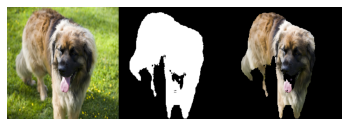

i= 2 loss= 0.24254373889671613 val_loss= 0.3098179471233617 mean_dsc= 0.9013585 val_mean_dsc= 0.87502813


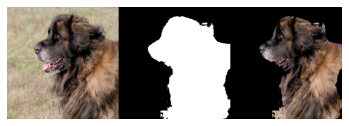

i= 3 loss= 0.22616321763627606 val_loss= 0.2849684513133505 mean_dsc= 0.9088458 val_mean_dsc= 0.88918924


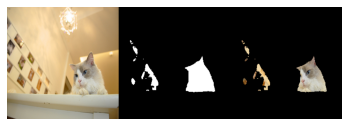

i= 4 loss= 0.21723143174631954 val_loss= 0.25703816504582117 mean_dsc= 0.91213644 val_mean_dsc= 0.8993819


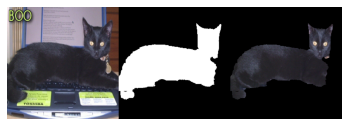

i= 5 loss= 0.20435731495692305 val_loss= 0.3175909506238025 mean_dsc= 0.91728675 val_mean_dsc= 0.8795605


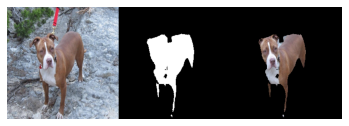

i= 6 loss= 0.1993057846716822 val_loss= 0.27935896813869476 mean_dsc= 0.91985977 val_mean_dsc= 0.8915681


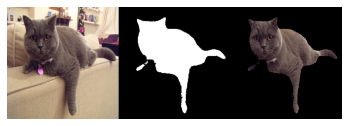

i= 7 loss= 0.18356279275256748 val_loss= 0.25494680586068524 mean_dsc= 0.9250862 val_mean_dsc= 0.9004962


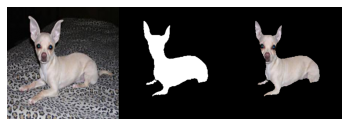

i= 8 loss= 0.1743535120805649 val_loss= 0.27288975080718164 mean_dsc= 0.929607 val_mean_dsc= 0.899534


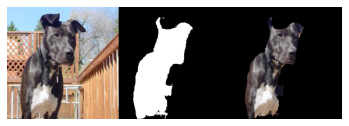

i= 9 loss= 0.16547543564003353 val_loss= 0.290544916106307 mean_dsc= 0.93255776 val_mean_dsc= 0.8929844


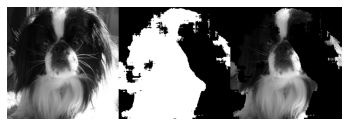

i= 10 loss= 0.1630853570181213 val_loss= 0.29213845146738965 mean_dsc= 0.9338144 val_mean_dsc= 0.88679785


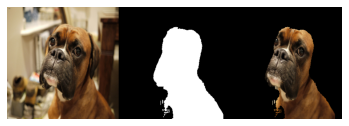

i= 11 loss= 0.1545279281188364 val_loss= 0.2818665096293325 mean_dsc= 0.9365963 val_mean_dsc= 0.8982179


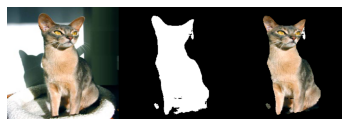

i= 12 loss= 0.1512543463475628 val_loss= 0.2758625123811805 mean_dsc= 0.9386737 val_mean_dsc= 0.8972399


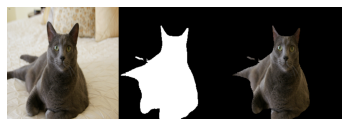

i= 13 loss= 0.14255300861651496 val_loss= 0.26162118043588556 mean_dsc= 0.9411226 val_mean_dsc= 0.89827746


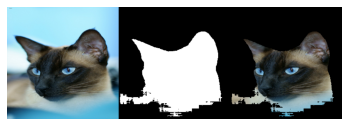

i= 14 loss= 0.13708081086204477 val_loss= 0.2542833666438642 mean_dsc= 0.9439771 val_mean_dsc= 0.90402603


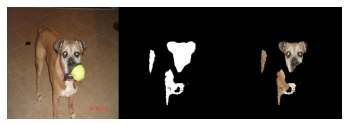

i= 15 loss= 0.13223340501796166 val_loss= 0.28720602781876275 mean_dsc= 0.9459792 val_mean_dsc= 0.89438796


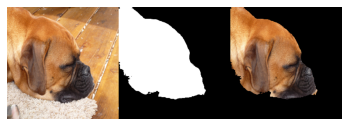

i= 16 loss= 0.12954247652735884 val_loss= 0.2291412003662275 mean_dsc= 0.94663894 val_mean_dsc= 0.9117262


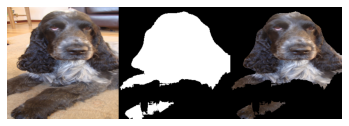

i= 17 loss= 0.1258463551158502 val_loss= 0.25322021090466046 mean_dsc= 0.94851303 val_mean_dsc= 0.9055884


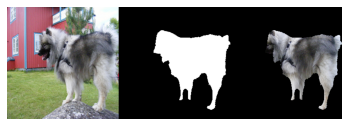

i= 18 loss= 0.12337077839393594 val_loss= 0.2787135729323263 mean_dsc= 0.94961524 val_mean_dsc= 0.90457964


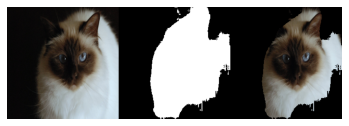

i= 19 loss= 0.1195796936342161 val_loss= 0.2629250424063724 mean_dsc= 0.9507797 val_mean_dsc= 0.90804607


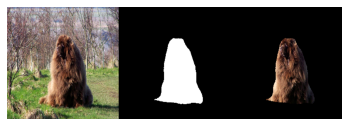

i= 20 loss= 0.11484213544217418 val_loss= 0.2531908588564914 mean_dsc= 0.95255524 val_mean_dsc= 0.9112364


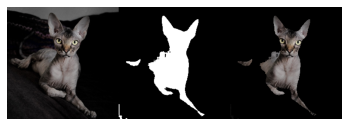

In [20]:
model.fit_generator(train_generator, 
                    epochs = 20, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

### Testing

In [21]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-05-13 09:24:07--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 54.230.183.2, 54.230.183.7, 54.230.183.91, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|54.230.183.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.02s   

2020-05-13 09:24:07 (3.56 MB/s) - ‘test.jpg’ saved [63219/63219]



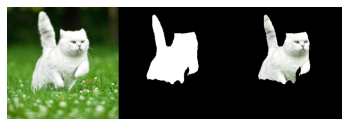

In [22]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

pred = model.predict(np.expand_dims(raw, 0))

msk = np.argmax(pred, axis=-1)
msk  = msk.squeeze()
msk = np.stack((msk,)*3, axis=-1)

combined = np.concatenate([raw, msk, raw* msk], axis = 1)

plt.axis('off')
plt.imshow(combined)
plt.show()